# Compare ICON ABI Synsat with GOES 16 ABI Observations

Here, we will have a look into the Synsat example data created with notebook [04-Run-Synsat-on-ICON-Data-for-SEVIRI.ipynb](04-Run-Synsat-on-ICON-Data-for-SEVIRI.ipynb).

A similar application is presented for ERA5 data in [03-Compare-ERA5-SEVIRI-Synsat-to-Meteosat-Obs.ipynb](03-Compare-ERA5-SEVIRI-Synsat-to-Meteosat-Obs.ipynb).

## Libraries 

### Setup Env and Load Libraries 

In [ ]:
import os, sys
os.environ['RTTOV_PYTHON_WRAPPER'] = '/work/bb1262/tools/rttov/rttov-v13.2/wrapper'

In [2]:
import synsatipy

import synsatipy.utils.colormaps as colormaps
import synsatipy.utils.timetools as timetools


### Import Standard Libraries 

In [3]:
import xarray as xr
xr.set_options(keep_attrs=True)

import numpy as np

import pylab as plt
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings("ignore")

## Specific GOES Libs

In [4]:
import goes2go
from pyproj import Proj, Geod

## Data Input 

### Input GOES Data

#### Load Data from Cloud

In [5]:
G = goes2go.GOES( satellite="G16", product="ABI", domain = 'F', )#bands=[13,14,])


In [6]:
goes_in = G.nearesttime('2020-09-12')

 👮🏻‍♂️ File already exists. Do not overwrite: /work/bb1376/work_archive/bm0834/data/noaa-goes16/ABI-L2-MCMIPF/2020/256/00/OR_ABI-L2-MCMIPF-M6_G16_s20202560000192_e20202560009506_c20202560010006.nc
📦 Finished downloading [1] files to [/work/bb1376/work_archive/bm0834/data/noaa-goes16/ABI-L2-MCMIPF].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

#### Change Variable Naming

In [7]:
varname_map = { 
    "CMI_C08":"bt062",
    "CMI_C09":"bt069",        
    "CMI_C10":"bt073",
    "CMI_C11":"bt084",        
    "CMI_C12":"bt096",
    "CMI_C13":"bt103",
    "CMI_C14":"bt112",
    "CMI_C15":"bt123",
    "CMI_C16":"bt133",
}
source_names = list( varname_map )

In [8]:
goes = goes_in[source_names + ['goes_imager_projection']].rename_vars( varname_map)

#### Care for Coordinates

In [9]:


"""
Because the GOES data comes in without latitude/longitude values, we need to calculate those. 
"""

def add_goes_coords(goes_dataset):
    # Create projection object using GOES-16 projection info:
    g16_proj = Proj(
        proj="geos",
        h=goes_dataset.goes_imager_projection.perspective_point_height,
        lon_0=goes_dataset.goes_imager_projection.longitude_of_projection_origin,
        lat_0=goes_dataset.goes_imager_projection.latitude_of_projection_origin,
        sweep=goes_dataset.goes_imager_projection.sweep_angle_axis,
    )

    # Map x/y coords in goes_dataset to lat/lon:
    lon, lat = g16_proj(
        *np.meshgrid(
            goes_dataset.x.values * goes_dataset.goes_imager_projection.perspective_point_height, 
            goes_dataset.y.values * goes_dataset.goes_imager_projection.perspective_point_height, 
        ), 
        inverse=True, 
    )

    # Return goes_dataset with lat and lon added to coordinates:
    return goes_dataset.assign_coords(
        lon=(("y", "x"), lon), 
        lat=(("y", "x"), lat), 
    )

In [10]:
goes = add_goes_coords( goes )

In [11]:
# dirty hack to replace nans with -99 in coordinates
goes['lon'][:] = np.where( np.isfinite(goes.lon), goes.lon, -99 )
goes['lat'][:] = np.where( np.isfinite(goes.lat), goes.lat, -99 )


### Input ICON Synsat Data 

In [12]:
synsatfile = './Data/abi_synsat_icon_example_data.nc'

if not os.path.isfile( synsatfile ):
    raise SystemExit('Synsatfile not found')
    
else:
     icon_synsat = xr.open_dataset( synsatfile )

## Plotting

In [13]:
lat_range = np.logical_and( goes.lat > 0, goes.lat < 45 )
lon_range = np.logical_and( goes.lon > -85, goes.lon < -25 )
mask = lon_range & lat_range

In [14]:
goes = goes.where(mask ).dropna('x', how = 'all').dropna('y', how = 'all')

In [15]:
def map_plotter(v, title = None, **spkws):
    
    map = v.plot(**spkws)

    map.axes.coastlines(color = 'white')
    map.axes.set_extent([-85, -25, 0, 45], crs=ccrs.PlateCarree())

    if title is not None:
        spkws['ax'].set_title(title)
    #fig = plt.gcf()
    #fig.set_size_inches(18, 5)

### Window Channel 

In [16]:
pkws = dict(     
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.6, },#"aspect": 40},
)


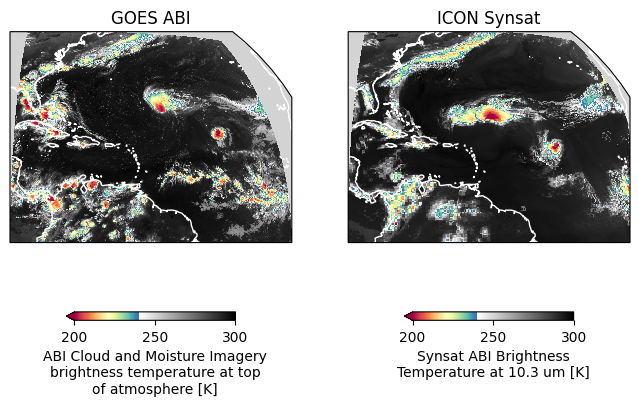

In [17]:
spkws = dict(     
    cmap=colormaps.enhanced_colormap(),
    vmin=200,
    vmax=300, **pkws
)

fig, axs = plt.subplots( ncols = 2, figsize = (8,6,), subplot_kw=dict(
        projection=ccrs.Geostationary(-75.2), facecolor="lightgray", 
    ),)

map_plotter( goes['bt103'], title = 'GOES ABI', ax = axs[0], **spkws ) 
map_plotter( icon_synsat['bt103'], title = 'ICON Synsat', ax = axs[1], **spkws ) 

### Water Vapor Channels 

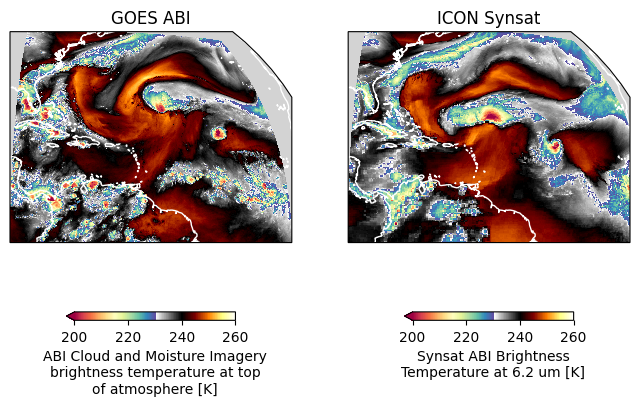

In [18]:
spkws = dict(     
    cmap=colormaps.enhanced_wv62_cmap(),
    vmin=200,
    vmax=260,
    **pkws )


fig, axs = plt.subplots( ncols = 2, figsize = (8,6,), subplot_kw=dict(
        projection=ccrs.Geostationary(-75.2), facecolor="lightgray", 
    ),)

map_plotter( goes['bt062'], title = 'GOES ABI', ax = axs[0], **spkws ) 
map_plotter( icon_synsat['bt062'], title = 'ICON Synsat', ax = axs[1], **spkws ) 

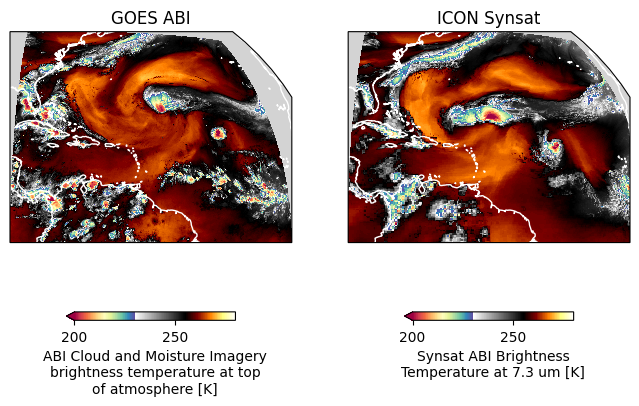

In [19]:
spkws = dict(     
    cmap=colormaps.enhanced_wv62_cmap(vmed2 = 255, vmax = 280),
    vmin=200,
    vmax=280,
    **pkws )

fig, axs = plt.subplots( ncols = 2, figsize = (8,6,), subplot_kw=dict(
        projection=ccrs.Geostationary(-75.2), facecolor="lightgray", 
    ),)

map_plotter( goes['bt073'], title = 'GOES ABI', ax = axs[0], **spkws ) 
map_plotter( icon_synsat['bt073'], title = 'ICON Synsat', ax = axs[1], **spkws ) 

### BT Differences 

In [20]:
for d in [goes, icon_synsat]:
    d['BTD_103_123']  = d['bt103'] - d['bt123']
    d['BTD_084_123']  = d['bt084'] - d['bt123']
    d['BTD_084_103']  = d['bt084'] - d['bt103']
    
    
    longname_suffix = d['bt103'].long_name.replace('at 10.3 um', 'Difference')
    d['BTD_103_123'].attrs['long_name'] = f'{longname_suffix} between 10.3 and 12.3 um'
    d['BTD_084_123'].attrs['long_name'] = f'{longname_suffix} between  8.7 and 12.0 um'
    d['BTD_084_103'].attrs['long_name'] = f'{longname_suffix} between  8.7 and 10.8 um'
    

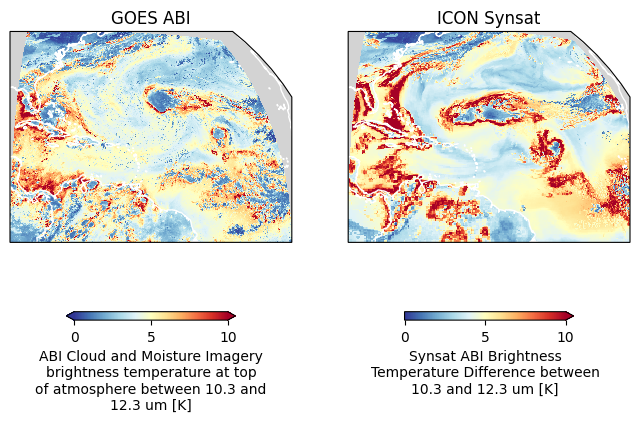

In [21]:
spkws = dict(     
    cmap=plt.cm.RdYlBu_r,
    vmin=0,
    vmax=10,
    **pkws )

fig, axs = plt.subplots( ncols = 2, figsize = (8,6,), subplot_kw=dict(
        projection=ccrs.Geostationary(-75.2), facecolor="lightgray", 
    ),)

map_plotter( goes['BTD_103_123'], title = 'GOES ABI', ax = axs[0], **spkws ) 
map_plotter( icon_synsat['BTD_103_123'], title = 'ICON Synsat', ax = axs[1], **spkws ) 

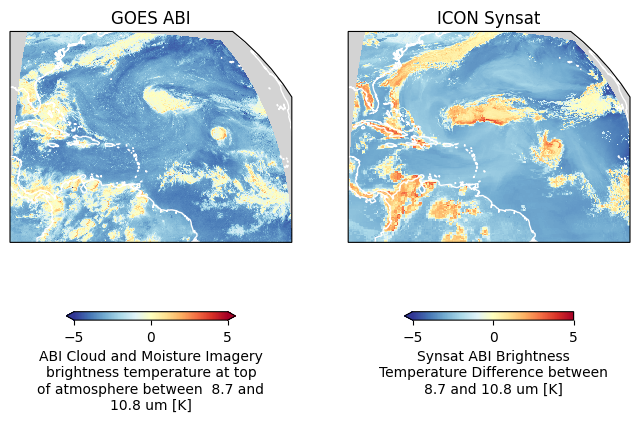

In [22]:
spkws = dict(     
    cmap=plt.cm.RdYlBu_r,
    vmin=-5,
    vmax=5,
    **pkws )

fig, axs = plt.subplots( ncols = 2, figsize = (8,6,), subplot_kw=dict(
        projection=ccrs.Geostationary(-75.2), facecolor="lightgray", 
    ),)

map_plotter( goes['BTD_084_103'], title = 'GOES ABI', ax = axs[0], **spkws ) 
map_plotter( icon_synsat['BTD_084_103'], title = 'ICON Synsat', ax = axs[1], **spkws ) 

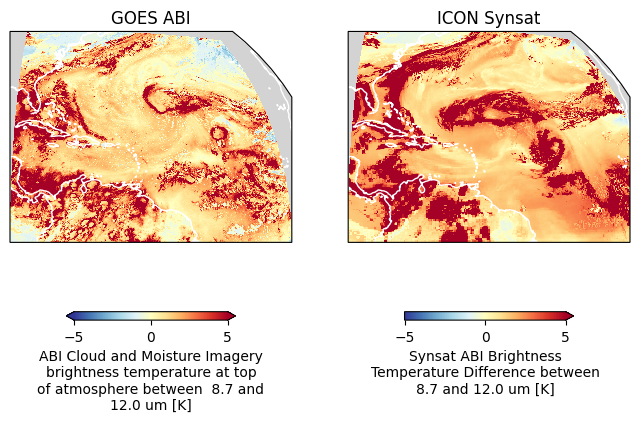

In [23]:
spkws = dict(     
    cmap=plt.cm.RdYlBu_r,
    vmin=-5,
    vmax=5,
    **pkws )

fig, axs = plt.subplots( ncols = 2, figsize = (8,6,), subplot_kw=dict(
        projection=ccrs.Geostationary(-75.2123), facecolor="lightgray", 
    ),)

map_plotter( goes['BTD_084_123'], title = 'GOES ABI', ax = axs[0], **spkws ) 
map_plotter( icon_synsat['BTD_084_123'], title = 'ICON Synsat', ax = axs[1], **spkws ) 